In [2]:
import tensorflow as tf
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import utils
import scoring
import numpy as np

from skopt import Optimizer
from skopt.learning.gaussian_process.kernels import Matern, RBF, WhiteKernel
from skopt.learning import RandomForestRegressor
from skopt.acquisition import gaussian_ei as acq_func
from IPython import display

Using TensorFlow backend.


In [ ]:
### Importing and structuring data ###

DATA_PATH = "./data/"
train, test = utils.load_data_csv(DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)

PointResiduals,Angles,LineSlope, FirstPointResiduals, FourthPointResiduals = utils.kink(train)
train['PointResiduals'] = pd.Series(PointResiduals, index=train.index)
train['Angles'] = pd.Series(PointResiduals, index=train.index)
train['LineSlope'] = pd.Series(PointResiduals, index=train.index)
train['FirstPointResiduals'] = pd.Series(PointResiduals, index=train.index)
train['FourthPointResiduals'] = pd.Series(PointResiduals, index=train.index)


train_part, val_part = train_test_split(train, test_size=0.20, shuffle=True)
x_train = train_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values
x_val   =  val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values
y_train = train_part.loc[:, ["label"]].values
y_val = val_part.loc[:, ["label"]].values
#y_train_weight = train_part.loc[:, ["weight"]].values

# turn labels into categorical classes
classes = [0,1]
y_train = keras.utils.to_categorical(y_train, num_classes=len(classes))
y_val   = keras.utils.to_categorical(y_val,   num_classes=len(classes))

In [3]:
### Defining utils ###

# Rectified linear unit

def relu(x):
  return np.array([ (i>0) * abs(i) for i in x ])

# plotting the bayesian optimizer

def plot_bo(bo, suggestion=None, value=None):
    a, b = bo.space.bounds[0]
    
    # getting the latest model
    model = bo.models[-1]
    
    xs = np.linspace(a, b, num=100)
    x_model = bo.space.transform(xs.reshape(-1, 1).tolist())
    
    mean, std = model.predict(x_model, return_std=True)
    
    plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.scatter(
        np.array(bo.Xi)[:, 0],
        np.array(bo.yi),
        color='red',
        label='observations'
    )
    if suggestion is not None:
        plt.scatter([suggestion], value, color='blue', label='suggestion')
    
    plt.plot(xs, mean, color='green', label='model')
    plt.fill_between(xs, mean - 1.96 * std, mean + 1.96 * std, alpha=0.1, color='green')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    acq = acq_func(x_model, model, np.min(bo.yi))
    plt.plot(xs, acq, label='Expected Improvement')
    plt.legend()
    
    plt.show()

# 

def cum_min(xs):
    result = np.zeros_like(xs)
    cmin = xs[0]
    
    result[0] = xs[0]
    
    for i in range(1, xs.shape[0]):
        if cmin > xs[i]:
            cmin = xs[i]

        result[i] = cmin
    
    return result

# plots progress of BO over time

def plot_convergence(bo):
    display.clear_output(wait=True)
    values = np.array(bo.yi)
    
    plt.figure(figsize=(12, 6))
    plt.plot(cum_min(values), label='minimal discovered')
    plt.scatter(np.arange(len(bo.yi)), bo.yi, label='observations')
    plt.xlabel('step', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    
    plt.legend(loc='upper right', fontsize=18)
    
    plt.show()

# Prints best parameters
    
def print_best(bo):
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    NodesInFirstDense, NodesInSecondDense, DropoutValue, INIT_LEARNINGRATE = best_parameters
    
    print(
        'Best model:\n Nodes in first dense layer= {0} \n Nodes in second dense layer= {1} \n learning rate= {2} \n Dropout value= {3}'.format(
            int(np.ceil(NodesInFirstDense)),
            int(np.ceil(NodesInSecondDense)),
            INIT_LEARNINGRATE,
            DropoutValue
        )
    )

In [4]:
### Target function with as input optimizeable parameters ###

def target_function1(params, X_train=x_train, y_train=y_train, X_score=x_val, y_score=y_val):
    
    # Optimized parameters
    NodesInFirstDense, NodesInSecondDense, INIT_LEARNINGRATE, DropoutValue = params
    
    
    # Making sure that the number of nodes are integers
    NodesInFirstDense = int(np.ceil(NodesInFirstDense))
    NodesInSecondDense = int(np.ceil(NodesInSecondDense))
    
    # Two parameters not optimized in this case, but can be optimized if needed
    BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
    EPOCHS = 3

    assert len(y_train) == len(x_train), "x_train and y_train not same length!"
    #assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Dropout
    from keras.layers.normalization import BatchNormalization

    K.clear_session()

    model = Sequential()
    model.add(Dense(NodesInFirstDense, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
    model.add(BatchNormalization())
    model.add(Dropout(DropoutValue))
    model.add(Dense(NodesInSecondDense , activation='relu'))
    model.add(Dense( len(classes) )) # muon and 'other'
    model.add(Activation("softmax")) # output probabilities

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
        metrics=['accuracy'] 
        )


    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )

    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    return 1 - result

In [5]:
def target_function2(params, X_train=x_train, y_train=y_train, X_score=x_val, y_score=y_val):
    
    # Optimized parameters
    NodesInFirstDense, NodesInSecondDense, NodesInThirdDense, INIT_LEARNINGRATE, DropoutValue  = params
    
    # Making sure that the number of nodes are integers
    NodesInFirstDense = int(np.ceil(NodesInFirstDense))
    NodesInSecondDense = int(np.ceil(NodesInSecondDense))
    NodesInThirdDense = int(np.ceil(NodesInThirdDense))
    
    # Two parameters not optimized in this case, but can be optimized if needed
    BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
    EPOCHS = 3

    assert len(y_train) == len(x_train), "x_train and y_train not same length!"
    #assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Dropout
    from keras.layers.normalization import BatchNormalization

    K.clear_session()

    model = Sequential()
    model.add(Dense(NodesInFirstDense, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
    model.add(BatchNormalization())
    model.add(Dropout(DropoutValue))
    model.add(Dense(NodesInSecondDense , activation='relu'))
    model.add(Dense(NodesInThirdDense )) # muon and 'other'
    model.add(Dense( len(classes) )) # muon and 'other'
    model.add(Activation("softmax")) # output probabilities

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
        metrics=['accuracy'] 
        )


    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )

    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    return 1 - result

In [6]:
def target_function3(params, X_train=x_train, y_train=y_train, X_score=x_val, y_score=y_val):
    
    # Optimized parameters
    NodesInFirstDense, NodesInSecondDense, NodesInThirdDense, NodesInFourthDense, INIT_LEARNINGRATE, DropoutValue = params
    
    # Making sure that the number of nodes are integers
    NodesInFirstDense = int(np.ceil(NodesInFirstDense))
    NodesInSecondDense = int(np.ceil(NodesInSecondDense))
    NodesInThirdDense = int(np.ceil(NodesInThirdDense))
    NodesInFourthDense = int(np.ceil(NodesInFourthDense))
    
    # Two parameters not optimized in this case, but can be optimized if needed
    BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
    EPOCHS = 3

    assert len(y_train) == len(x_train), "x_train and y_train not same length!"
    #assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Dropout
    from keras.layers.normalization import BatchNormalization

    K.clear_session()

    model = Sequential()
    model.add(Dense(NodesInFirstDense, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
    model.add(BatchNormalization())
    model.add(Dense(NodesInSecondDense , activation='relu'))
    model.add(Dense(NodesInThirdDense )) # muon and 'other'
    model.add(Dropout(DropoutValue))
    model.add(Dense(NodesInFourthDense )) # muon and 'other'
    model.add(Dense( len(classes) ))
    model.add(Activation("softmax")) # output probabilities

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
        metrics=['accuracy'] 
        )


    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )

    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    return 1 - result

In [7]:
def target_function4(params, X_train=x_train, y_train=y_train, X_score=x_val, y_score=y_val):
    
    # Optimized parameters
    NodesInFirstDense, NodesInSecondDense, NodesInThirdDense, NodesInFourthDense,NodesInFifthDense, INIT_LEARNINGRATE, DropoutValue = params
    
    # Making sure that the number of nodes are integers
    NodesInFirstDense = int(np.ceil(NodesInFirstDense))
    NodesInSecondDense = int(np.ceil(NodesInSecondDense))
    NodesInThirdDense = int(np.ceil(NodesInThirdDense))
    NodesInFourthDense = int(np.ceil(NodesInFourthDense))
    NodesInFifthDense = int(np.ceil(NodesInFifthDense))
    
    # Two parameters not optimized in this case, but can be optimized if needed
    BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
    EPOCHS = 3

    assert len(y_train) == len(x_train), "x_train and y_train not same length!"
    #assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Dropout
    from keras.layers.normalization import BatchNormalization

    K.clear_session()

    model = Sequential()
    model.add(Dense(NodesInFirstDense, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
    model.add(BatchNormalization())
    model.add(Dense(NodesInSecondDense , activation='relu'))
    model.add(Dense(NodesInThirdDense )) # muon and 'other'
    model.add(Dropout(DropoutValue))
    model.add(Dense(NodesInFourthDense )) # muon and 'other'
    model.add(Dense(NodesInFifthDense ))
    model.add(Dense( len(classes) ))
    model.add(Activation("softmax")) # output probabilities


    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
        metrics=['accuracy'] 
        )


    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )

    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    return 1 - result

In [8]:
def target_function_NoBatch(params, X_train=x_train, y_train=y_train, X_score=x_val, y_score=y_val):
    
    # Optimized parameters
    NodesInFirstDense, NodesInSecondDense, INIT_LEARNINGRATE, DropoutValue = params
    
    # Making sure that the number of nodes are integers
    NodesInFirstDense = int(np.ceil(NodesInFirstDense))
    NodesInSecondDense = int(np.ceil(NodesInSecondDense))
    
    # Two parameters not optimized in this case, but can be optimized if needed
    BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
    EPOCHS = 3

    assert len(y_train) == len(x_train), "x_train and y_train not same length!"
    #assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

    from keras.models import Sequential
    from keras.layers import Dense, Activation, Dropout

    K.clear_session()

    model = Sequential()
    model.add(Dense(NodesInFirstDense, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
    model.add(Dropout(DropoutValue))
    model.add(Dense(NodesInSecondDense , activation='relu'))
    model.add(Dense( len(classes) ))
    model.add(Activation("softmax")) # output probabilities

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
        metrics=['accuracy'] 
        )


    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )

    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    return 1 - result

In [9]:
### Setting dimensions for optimizeable parameters ###

dimensions_4 =[
    # NodesInFirstDense
    (4.0, 300.0),
    
    # NodesInSecondDense
    (4.0, 300.0),
    
    # LOG_INIT_LEARNINGRATE
    (1.0e-4, 1.0e-2),
    
    # DropoutValue
    (0.0, 0.1)
]

dimensions_5 =[
    # NodesInFirstDense
    (4.0, 300.0),
    
    # NodesInSecondDense
    (4.0, 300.0),
    
    # NodesInThirdDense
    (4.0, 300.0),
    
    # LOG_INIT_LEARNINGRATE
    (1.0e-4, 1.0e-2),
    
    # DropoutValue
    (0.0, 0.1)
]

dimensions_6 =[
    # NodesInFirstDense
    (4.0, 300.0),
    
    # NodesInSecondDense
    (4.0, 300.0),
    
    # NodesInThirdDense
    (4.0, 300.0),
    
    # NodesInFourthDense
    (4.0, 300.0),
    
    # LOG_INIT_LEARNINGRATE
    (1.0e-4, 1.0e-2),
    
    # DropoutValue
    (0.0, 0.1)
]

dimensions_7 =[
    # NodesInFirstDense
    (4.0, 300.0),
    
    # NodesInSecondDense
    (4.0, 300.0),
    
    # NodesInThirdDense
    (4.0, 300.0),
    
    # NodesInFourthDense
    (4.0, 300.0),
    
    # NodesInFifthDense
    (4.0, 300.0),
    
    # LOG_INIT_LEARNINGRATE
    (1.0e-4, 1.0e-2),
    
    # DropoutValue
    (0.0, 0.1)
]

In [112]:
### Random forest regressor optimizer ###

bo_rf_41 = Optimizer(
    dimensions=dimensions_4,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=1,
    acq_func='EI',   
)

In [113]:
bo_rf_42 = Optimizer(
    dimensions=dimensions_5,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=1,
    acq_func='EI',   
)

In [114]:
bo_rf_43 = Optimizer(
    dimensions=dimensions_6,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=1,
    acq_func='EI',
)

In [115]:
bo_rf_44 = Optimizer(
    dimensions=dimensions_7,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=1,
    acq_func='EI',   
)

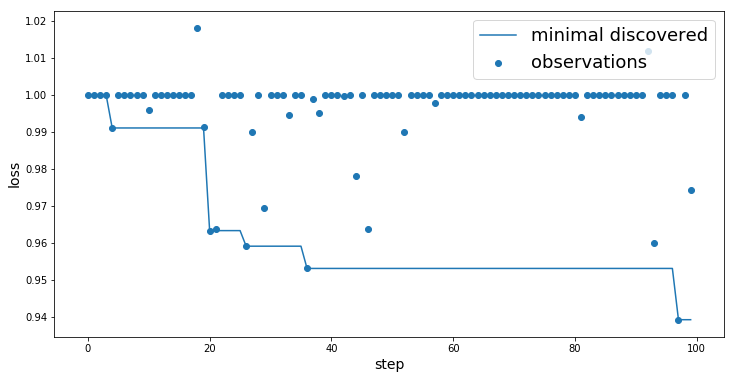

In [10]:
OptimalParams1 = ([])
OptimalParams2 = ([])
OptimalParams3= ([])
OptimalParams4= ([])
OptimalParams_NoBatch = ([])

OptimalScore1 = ([])
OptimalScore2 = ([])
OptimalScore3= ([])
OptimalScore4= ([])
OptimalScore_NoBatch = ([])

# First network, original network, two dense layers
for i in range(0,3):

    bo_rf_41 = Optimizer(
    dimensions=dimensions_4,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=10,
    acq_func='EI',   
    )

    bo = bo_rf_41

    for j in range(100):
        x = bo.ask()
        print(x)
        f = target_function1(x) # Other inputs are automatically set

        bo.tell(x, f)

        plot_convergence(bo)

    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    OptimalParams1 = np.append(OptimalParams1,best_parameters, axis=0)
    OptimalScore1 = np.append(OptimalScore1,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams1 = np.append(OptimalParams1,best_parameters, axis=0)
    OptimalScore1 = np.append(OptimalScore1,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams1 = np.append(OptimalParams1,best_parameters, axis=0)
    OptimalScore1 = np.append(OptimalScore1,bo.yi[np.argmin(bo.yi)])
    
    i += 1
    
# Second network, three dense layers
for i in range(0,3):

    bo_rf_42 = Optimizer(
    dimensions=dimensions_5,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=10,
    acq_func='EI',   
    )

    bo = bo_rf_42

    for j in range(150):
        x = bo.ask()
        print(x)
        f = target_function2(x) # Other inputs are automatically set

        bo.tell(x, f)

        plot_convergence(bo)

    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]


    OptimalParams2 = np.append(OptimalParams2, best_parameters, axis=0)
    OptimalScore2 = np.append(OptimalScore2,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams2 = np.append(OptimalParams2,best_parameters, axis=0)
    OptimalScore2 = np.append(OptimalScore2,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams2 = np.append(OptimalParams2,best_parameters, axis=0)
    OptimalScore2 = np.append(OptimalScore2,bo.yi[np.argmin(bo.yi)])
    
    i += 1

#Third network, four dense layers
for i in range(0,3):

    bo_rf_43 = Optimizer(
    dimensions=dimensions_6,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=10,
    acq_func='EI',   
    )

    bo = bo_rf_43

    for j in range(180):
        x = bo.ask()
        print(x)
        f = target_function3(x) # Other inputs are automatically set

        bo.tell(x, f)

        plot_convergence(bo)

    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    OptimalParams3 = np.append(OptimalParams3, best_parameters, axis=0)
    OptimalScore3 = np.append(OptimalScore3,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams3 = np.append(OptimalParams3,best_parameters, axis=0)
    OptimalScore3 = np.append(OptimalScore3,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams3 = np.append(OptimalParams3,best_parameters, axis=0)
    OptimalScore3 = np.append(OptimalScore3,bo.yi[np.argmin(bo.yi)])
    
    i += 1

# fourth network, five dense layers
for i in range(0,3):

    bo_rf_44 = Optimizer(
    dimensions=dimensions_7,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6
    ),
    n_initial_points=10,
    acq_func='EI',   
    )

    bo = bo_rf_44

    for j in range(200):
        x = bo.ask()
        print(x)
        f = target_function4(x) # Other inputs are automatically set

        bo.tell(x, f)

        plot_convergence(bo)

    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    OptimalParams4 = np.append(OptimalParams4, best_parameters, axis = 0)
    OptimalScore4 = np.append(OptimalScore4,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams4 = np.append(OptimalParams4,best_parameters, axis=0)
    OptimalScore4 = np.append(OptimalScore4,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams4 = np.append(OptimalParams4,best_parameters, axis=0)
    OptimalScore4 = np.append(OptimalScore4,bo.yi[np.argmin(bo.yi)])
    
    i += 1

# fifth network, No batch normalization
for i in range(0,3):        

    bo_rf_41 = Optimizer(
    dimensions=dimensions_4,
    base_estimator=RandomForestRegressor(
        n_estimators=100, n_jobs=4, min_variance=1.0e-6),
    n_initial_points=10,
    acq_func='EI',   
    )

    bo = bo_rf_41

    for j in range(100):
        x = bo.ask()
        print(x)
        f = target_function_NoBatch(x) # Other inputs are automatically set

        bo.tell(x, f)

        plot_convergence(bo)

    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]

    OptimalParams_NoBatch = np.append(OptimalParams_NoBatch, best_parameters, axis=0)
    OptimalScore_NoBatch = np.append(OptimalScore_NoBatch,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams_NoBatch = np.append(OptimalParams_NoBatch, best_parameters, axis=0)
    OptimalScore_NoBatch = np.append(OptimalScore_NoBatch,bo.yi[np.argmin(bo.yi)])
    
    bo.yi[np.argmin(bo.yi)] = 1
    
    best_result_index = np.argmin(bo.yi)
    best_parameters = bo.Xi[best_result_index]
    
    OptimalParams_NoBatch = np.append(OptimalParams_NoBatch,best_parameters, axis=0)
    OptimalScore_NoBatch = np.append(OptimalScore_NoBatch,bo.yi[np.argmin(bo.yi)])
    
    i += 1

In [41]:
OptimalParams2

array([2.18864702e+02, 1.93413741e+02, 1.69389836e+02, 4.89901119e-03,
       4.75497467e-04, 2.17454314e+02, 2.45456415e+02, 1.21090369e+02,
       7.89045064e-03, 1.98599347e-04, 2.29520992e+02, 2.52662374e+02,
       7.24999724e+01, 7.02080878e-03, 2.58987840e-02, 2.03231592e+02,
       1.50161741e+02, 3.57886484e+01, 7.54340476e-03, 2.87772593e-02,
       1.95569970e+02, 1.98146921e+02, 8.71746696e+01, 8.78714283e-03,
       2.18559220e-02, 1.95406677e+02, 7.52775069e+00, 1.88274985e+02,
       9.91639238e-03, 2.02738047e-02, 2.52549118e+02, 5.84586671e+01,
       2.79810692e+02, 7.70226925e-03, 1.61289666e-02, 1.26091507e+02,
       8.93294680e+01, 2.54268985e+02, 8.12768153e-03, 6.91654171e-02,
       1.90118898e+02, 1.22768945e+01, 2.60820247e+01, 8.69664986e-03,
       3.23522933e-02])

In [52]:
ResultsDict = {}
ResultsDict = {
    
                'First Network' : 
               
               { 
                 1 : {'Optimal Parameters' : OptimalParams1[0:12].tolist(), 'Optimal Score' : OptimalScore1[0:3].tolist()}, 
                 2 : {'Optimal Parameters' : OptimalParams1[12:24].tolist(), 'Optimal Score' : OptimalScore1[3:6].tolist()},
                 3 : {'Optimal Parameters' : OptimalParams1[24:36].tolist(), 'Optimal Score' : OptimalScore1[6:9].tolist()}
               },
               
                'Second Network': 
               
               {
                 1 : {'Optimal Parameters' : OptimalParams2[0:15].tolist(), 'Optimal Score' : OptimalScore2[0:3].tolist()}, 
                 2 : {'Optimal Parameters' : OptimalParams2[15:30].tolist(), 'Optimal Score' : OptimalScore2[3:6].tolist()},
                 3 : {'Optimal Parameters' : OptimalParams2[30:45].tolist(), 'Optimal Score' : OptimalScore2[6:9].tolist()}
               },
    
                'Third Network':
    
               {
                 1 : {'Optimal Parameters' : OptimalParams3[0:18].tolist(), 'Optimal Score' : OptimalScore3[0:3].tolist()}, 
                 2 : {'Optimal Parameters' : OptimalParams3[18:36].tolist(), 'Optimal Score' : OptimalScore3[3:6].tolist()},
                 3 : {'Optimal Parameters' : OptimalParams3[36:54].tolist(), 'Optimal Score' : OptimalScore3[6:9].tolist()}
               },
                
                'Fourth Network':
    
               {
                 1 : {'Optimal Parameters' : OptimalParams4[0:21].tolist(), 'Optimal Score' : OptimalScore4[0:3].tolist()}, 
                 2 : {'Optimal Parameters' : OptimalParams4[21:42].tolist(), 'Optimal Score' : OptimalScore4[3:6].tolist()},
                 3 : {'Optimal Parameters' : OptimalParams4[42:61].tolist(), 'Optimal Score' : OptimalScore4[6:9].tolist()}
               },
    
                'No Batch Network':
    
               {
                 1 : {'Optimal Parameters' : OptimalParams_NoBatch[0:12].tolist(), 'Optimal Score' : OptimalScore_NoBatch[0:3].tolist()}, 
                 2 : {'Optimal Parameters' : OptimalParams_NoBatch[12:24].tolist(), 'Optimal Score' : OptimalScore_NoBatch[3:6].tolist()},
                 3 : {'Optimal Parameters' : OptimalParams_NoBatch[24:36].tolist(), 'Optimal Score' : OptimalScore_NoBatch[6:9].tolist()}
               }
    
               
              }


In [53]:
ResultsDict

{'First Network': {1: {'Optimal Parameters': [143.34642200432822,
    131.96813983771438,
    0.007174390867507205,
    0.0015448918050414708,
    198.3924233618323,
    297.9232168029428,
    0.007801482630416755,
    0.06662902909584964,
    98.16494516810752,
    14.202503608951396,
    0.007160021442941561,
    0.003514841233384059],
   'Optimal Score': [0.5636999845489836,
    0.5754790682183295,
    0.5776988793910585]},
  2: {'Optimal Parameters': [183.03214133090202,
    121.38054493411309,
    0.00997486989750012,
    0.037232122966179,
    182.98290987592586,
    76.02833662794394,
    0.009637258870804745,
    0.05527984826977263,
    182.997711061559,
    83.85173990935756,
    0.003434525525972969,
    0.057042667398588855],
   'Optimal Score': [0.5625060860537208,
    0.5666069302585266,
    0.5680965060262047]},
  3: {'Optimal Parameters': [283.782843456031,
    25.82482582363449,
    0.0048377559374729795,
    0.07748374917689638,
    284.9846638526855,
    123.22556910

In [54]:
import json

with open('data.json', 'w') as fp:
    json.dump(ResultsDict, fp, indent = 4)

In [50]:
OptimalParams1.tolist()

[143.34642200432822,
 131.96813983771438,
 0.007174390867507205,
 0.0015448918050414708,
 198.3924233618323,
 297.9232168029428,
 0.007801482630416755,
 0.06662902909584964,
 98.16494516810752,
 14.202503608951396,
 0.007160021442941561,
 0.003514841233384059,
 183.03214133090202,
 121.38054493411309,
 0.00997486989750012,
 0.037232122966179,
 182.98290987592586,
 76.02833662794394,
 0.009637258870804745,
 0.05527984826977263,
 182.997711061559,
 83.85173990935756,
 0.003434525525972969,
 0.057042667398588855,
 283.782843456031,
 25.82482582363449,
 0.0048377559374729795,
 0.07748374917689638,
 284.9846638526855,
 123.22556910915861,
 0.004839427337398802,
 0.05982455324282469,
 254.91075230970694,
 25.768421577791294,
 0.004891801439439815,
 0.06466796649056859]

In [64]:
First = []
for i in range(1,4):
    First = ResultsDict["First Network"][i]["Optimal Score"]
    First = sum(First / 3
    

First = sum(First)/3

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [63]:
ResultsDict["First Network"][2]["Optimal Score"]

[0.5625060860537208, 0.5666069302585266, 0.5680965060262047]

In [37]:
bo.yi[np.argmin(bo.yi)]

0.5414268371482693

In [39]:
best_result_index = np.argmin(bo.yi)
best_parameters = bo.Xi[best_result_index]
best_parameters

[173.2773707552993,
 14.45812940532587,
 0.007589349274725483,
 0.008446173333937724]

In [30]:
np.append(OptimalScore1,bo.yi[np.argmin(bo.yi)])

array([0.53841483])

In [23]:
best_result_index = np.argmin(bo.yi)
best_parameters = bo.Xi[best_result_index]

best_result_index
best_parameters
bo.yi[np.argmin(bo.yi)]

0.5900488114779627

In [ ]:
### Gaussian optimizer ###

bo_gp_1 = Optimizer(
    ### telling optimizer boundaries for each parameter
    dimensions=dimensions_1,
    
    ### setting regressor
    base_estimator=GaussianProcessRegressor(
        kernel=RBF(length_scale_bounds=[1.0e-6, 1.0e+6]) + \
            WhiteKernel(noise_level=1.0e-5, noise_level_bounds=[1.0e-6, 1.0e-2]),
    ),
    n_initial_points=2,
    acq_func='EI',   
)

In [37]:
### Actual optimization process ###
def Optimization(bo,target_function):
    Parameter_List = ([])
    for i in range(1):
        x = bo.ask()
        print(x)
        f = target_function(x) # Other inputs are automatically set

        Parameter_List = np.append(Parameter_List, x)
        bo.tell(x, f)

        plot_convergence(bo)
        
        best_result_index = np.argmin(bo.yi)
        best_parameters = bo.Xi[best_result_index]

In [21]:
print_best(bo_rf_4)

Best model:
 Nodes in first dense layer= 235 
 Nodes in second dense layer= 147 
 learning rate= 0.02177968898175681 
 Dropout value= 0.005580370632707155


In [9]:
### Testing the found parameters to see if the results are reproduceable ###

INIT_LEARNINGRATE = 0.02532767329545395  
BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
EPOCHS = 3

assert len(y_train) == len(x_train), "x_train and y_train not same length!"
#assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

K.clear_session()

model = Sequential()
model.add(Dense(271, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
model.add(BatchNormalization())
model.add(Dropout(0.0009682674694188368))
model.add(Dense(280, activation='relu'))
model.add(Dense( len(classes) )) # muon and 'other'
model.add(Activation("softmax")) # output probabilities

print(model.summary())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
    metrics=['accuracy'] 
    )

# Running test for 5 times in this case
for i in range(0,5):
    model.fit(
        x_train, y_train,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = (x_val, y_val),
        shuffle = True
        )


    #model.save_model("keras_basic_model.xgb")


    # score

    validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
    result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
    print(result)
    
    i += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 271)               17886     
_________________________________________________________________
batch_normalization_1 (Batch (None, 271)               1084      
_________________________________________________________________
dropout_1 (Dropout)          (None, 271)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 280)               76160     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 562       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 95,692
Trainable params: 95,150
Non-trainable params: 542
_________________________________________________________________
None

In [17]:
#### Original keras model for reference ####

INIT_LEARNINGRATE = 5e-3
BATCH_SIZE = 16  # should be a factor of len(x_train) and len(x_val) etc.
EPOCHS = 3

assert len(y_train) == len(x_train), "x_train and y_train not same length!"
#assert len(y_train) % BATCH_SIZE == 0, "batch size should be multiple of training size,{0}/{1}".format(len(y_train),BATCH_SIZE)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization

K.clear_session()

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=( len( utils.SIMPLE_FEATURE_COLUMNS ), ))) #length = input vars
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(50 , activation='relu'))
model.add(Dense( len(classes) )) # muon and 'other'
model.add(Activation("softmax")) # output probabilities

print(model.summary())

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.adamax(lr=INIT_LEARNINGRATE),
    metrics=['accuracy'] 
    )


model.fit(
    x_train, y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val, y_val),
    shuffle = True
    )

#model.save_model("keras_basic_model.xgb")


# score

validation_predictions = model.predict_proba(val_part.loc[:, utils.SIMPLE_FEATURE_COLUMNS].values)[:, 1]
result = scoring.rejection90(val_part.label.values, validation_predictions, sample_weight=val_part.weight.values)
print(result)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               6600      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 12,152
Trainable params: 11,952
Non-trainable params: 200
_________________________________________________________________
None

In [ ]:
for i in range(0,5):
    
    for j in range(0,5):
        
        

In [7]:
import multiprocessing

In [8]:
!nproc


'nproc' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
pool = multiprocessing.Pool(processes=4)

In [18]:
r = pool.map(model.fit, [x_train, y_train])

ValueError: Error when checking input: expected dense_1_input to have shape (65,) but got array with shape (2,)

In [11]:
i = 1
DataDict['FirstNetwork']['run {0}'.format(i)]

NameError: name 'DataDict' is not defined